In [12]:
# Imports (Non exhaustive)
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow API new structure for Tensorflow v2.15.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
# Directories definition
train_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/train"
test_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/test"
val_path = "C:/Users/user/Desktop/Chest Xray Classifier/dataset/val"

# Basic parameters (image dimension and batch size)
batch_size = 16
img_height = 500
img_width = 500

In [16]:
# Data Preparation

# Load data

train = tf.keras.utils.image_dataset_from_directory(train_path,
                                                    image_size=(img_height, img_width),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size)

test = tf.keras.utils.image_dataset_from_directory(test_path,
                                                   image_size=(img_height, img_width),
                                                   color_mode='grayscale',
                                                   shuffle=False, 
                                                   label_mode='binary',
                                                   batch_size=batch_size)

valid = tf.keras.utils.image_dataset_from_directory(val_path,
                                                    image_size=(img_height, img_width),
                                                    color_mode='grayscale',
                                                    label_mode='binary',
                                                    batch_size=batch_size)


Found 4192 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 1040 files belonging to 2 classes.


In [17]:
# Model Architecture (Input->CNN->Flat->ANN->Output)
cnn = Sequential()

# Preprocessing (data augmentation) layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),    
    ])
cnn.add(data_augmentation)

# Convolution and Pooling Layers
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten 
cnn.add(Flatten())

# Fully-connected Neural Network Layers
cnn.add(Dense(activation='relu', units = 128))
cnn.add(Dense(activation='relu', units = 64))
cnn.add(Dense(activation='relu', units = 64))
cnn.add(Dense(activation='sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Regularization callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=3) # Patience: no. of epochs to run after monitored parameter stops changing
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00001)
callbacks_ls = [early, learning_rate_reduction] 

# Class weights for unbalanced datasets
# Assign higher weights to the minority class, reduce bias towards majority class
# Calculate proportion, invert it as a counter-bias
# from sklearn.utils.class_weight import compute_class_weight
# weights = compute_class_weight('balanced', np.unique(train.class_names))
# class_weight_val = dict(zip(np.unique(train.class_names), weights))
# #print(class_weight_val)

Epoch 1/10


262/262 [==============================] - 546s 2s/step - loss: 0.3454 - accuracy: 0.8387 - val_loss: 0.2696 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 2/10
262/262 [==============================] - 542s 2s/step - loss: 0.2724 - accuracy: 0.8860 - val_loss: 0.3015 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 3/10
262/262 [==============================] - 551s 2s/step - loss: 0.2415 - accuracy: 0.9024 - val_loss: 0.2833 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/10
262/262 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.9125
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 541s 2s/step - loss: 0.2208 - accuracy: 0.9125 - val_loss: 0.5205 - val_accuracy: 0.7885 - lr: 0.0010


<AxesSubplot:>

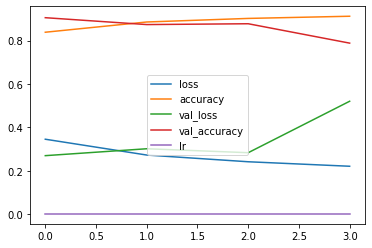

In [19]:
# Train model (run this cell to train)
# cnn.fit(train, epochs=30, validation_data=valid, class_weight=class_weight_val, callbacks=callbacks_ls)
cnn.fit(train, epochs=10, validation_data=valid, callbacks=callbacks_ls)
# Training metric visualization
pd.DataFrame(cnn.history.history).plot()

In [23]:
# Model evaluation
test_model = cnn.evaluate(test)
test_accu = test_model[1] * 100
print('Test Accuracy: ', test_accu, '%')

# Assign binary classes to prediction output (Sigmoid: 0 < output < 1)
prediction = cnn.predict(test, verbose=1)
prediction_bin = prediction.copy()
prediction_bin[prediction_bin <=0.5 ] = 0
prediction_bin[prediction > 0.5] = 1

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
con_mat = pd.DataFrame(data=confusion_matrix(test.class_names, prediction_bin, labels=[0, 1]),
                       index=["Actual Normal", "Actual Pneumonia"],
                       columns=["Predicted Normal", "Predicted Pneumonia"])
print(classification_report(y_true=test.classes, y_pred=prediction_bin, target_names=['NORMAL','PNEUMONIA']))

39/39 [==============================] - 14s 362ms/step - loss: 0.3664 - accuracy: 0.8429
Test Accuracy:  84.29487347602844 %
39/39 [==============================] - 16s 405ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2, 624]